# Demo Model

In [1]:
import pandas as pd
data = pd.read_csv('./out.csv')
data.head()

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,Lyric,language
0,1,https://www.last.fm/music/metallica/_/st.%2banger,St. Anger,Metallica,['aggressive'],8,3.710000,5.833000,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,3fOc9x06lKJBhz435mInlH,metal,Saint Anger 'round my neck\nSaint Anger 'round...,en
1,3,https://www.last.fm/music/m.i.a./_/bamboo%2bbanga,Bamboo Banga,M.I.A.,"['aggressive', 'fun', 'sexy', 'energetic']",13,6.555071,5.537214,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,6tqFC1DIOphJkCwrjVzPmg,hip-hop,"Road runner, road runner\nGoing hundred mile p...",en
2,5,https://www.last.fm/music/drowning%2bpool/_/st...,Step Up,Drowning Pool,['aggressive'],9,2.971389,5.537500,4.726389,49e7b4d2-3772-4301-ba25-3cc46ceb342e,4Q1w4Ryyi8KNxxaFlOQClK,metal,Come!\n\nIf our own lives aren’t directly affe...,en
3,11,https://www.last.fm/music/kanye%2bwest/_/feedback,Feedback,Kanye West,['aggressive'],1,3.080000,5.870000,5.490000,NaN,49fT6owWuknekShh9utsjv,hip-hop,"Ayy, y'all heard about the good news?\nY'all s...",en
4,13,https://www.last.fm/music/deftones/_/7%2bwords,7 Words,Deftones,"['aggressive', 'angry']",10,3.807121,5.473939,4.729091,1a826083-5585-445f-a708-415dc90aa050,6DoXuH326aAYEN8CnlLmhP,nu metal,"I'll never be the same, breaking decency\nDon'...",en


In [2]:
data['word-len'] = data['Lyric'].apply(lambda i: len(i.split(' ')))

<AxesSubplot: >

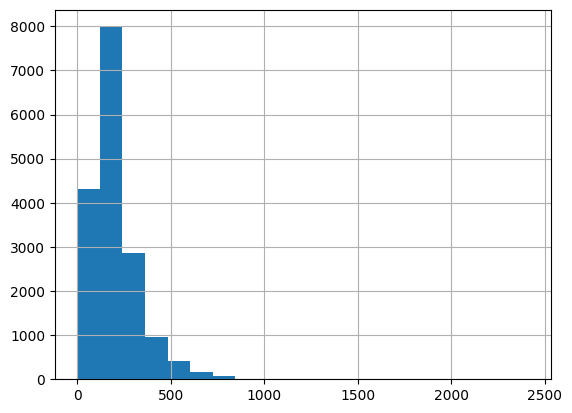

In [3]:
data['word-len'].hist(bins=20)

In [4]:
CUTOFF = int(data['word-len'].mean() + data['word-len'].std())

In [5]:
import re
data['no-punct'] = data['Lyric'].apply(lambda i: re.sub(r'[^\w\s]', '', i))
data['no-punct'] = data['no-punct'].apply(lambda i: i.lower())
data['words-split'] = data['no-punct'].apply(lambda i: re.split(' |\n', i))
data['words-split'] = data['words-split'].apply(lambda i: [j for j in i if j])

In [6]:
data['words-split'].head()

0    [saint, anger, round, my, neck, saint, anger, ...
1    [road, runner, road, runner, going, hundred, m...
2    [come, if, our, own, lives, arent, directly, a...
3    [ayy, yall, heard, about, the, good, news, yal...
4    [ill, never, be, the, same, breaking, decency,...
Name: words-split, dtype: object

In [7]:
data['trimmed'] = data['words-split'].apply(lambda i: i[:CUTOFF] if len(i) > CUTOFF else i)

In [8]:
import numpy as np
all_words = np.concatenate(data['trimmed'])
unique_words, counts = np.unique(all_words, return_counts=True)

In [9]:
sorted_words = unique_words[counts.argsort()[::-1]]

In [10]:
VOCAB_SIZE = 3000
most_common_words = sorted_words[:VOCAB_SIZE]

In [15]:
import numpy as np
# Add padding as empty string (all empty strings have already been removed by this point)
data['padded'] = data['trimmed'].apply(lambda i: i + [''] * (CUTOFF - len(i)))
trimmed_2d = np.stack(data['padded'])

most_common_words = np.concatenate([[''], most_common_words])

from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm as tqdm
enc = LabelBinarizer(sparse_output=True)  # Sparse matrix due to resource constraints
enc.fit(most_common_words)
encodings = np.array([enc.transform(trimmed_2d[i]) for i in tqdm(range(len(trimmed_2d)))])
encodings.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16797/16797 [00:17<00:00, 940.31it/s]


(16797,)

In [11]:
import tensorflow as tf

in_size = VOCAB_SIZE + 1

inputs = tf.keras.layers.Input((CUTOFF, in_size))
x = tf.keras.layers.Dense(in_size // 100, activation='relu')(inputs)
x = tf.keras.layers.Conv1D(100, 25, activation='relu')(x)
x = tf.keras.layers.MaxPool1D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(in_size // 100, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=.1)(x)
x = tf.keras.layers.Dense(in_size // 100, activation='relu')(x)
x = tf.keras.layers.Dense(3)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 329, 3001)]       0         
                                                                 
 dense (Dense)               (None, 329, 30)           90060     
                                                                 
 conv1d (Conv1D)             (None, 305, 100)          75100     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 100)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 15200)             0         
                                                                 
 dense_1 (Dense)             (None, 30)                456030    
                           

2023-03-08 10:07:39.104101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 10:07:39.104389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
def normalize(inp: np.ndarray) -> np.ndarray:
    return (inp - inp.mean()) / inp.std()

valence_norm = normalize(data['valence_tags'].to_numpy())
arousal_norm = normalize(data['arousal_tags'].to_numpy())
dominance_norm = normalize(data['arousal_tags'].to_numpy())

data['valence_norm'] = valence_norm
data['arousal_norm'] = arousal_norm
data['dominance_norm'] = dominance_norm

labels = np.stack([valence_norm, arousal_norm, dominance_norm], axis=1)
labels.shape

(16797, 3)

In [19]:
import numpy as np
def random_epoch(x_train, x_val, y_train, y_val, batch_size=100, sample_size=1000):
    # Procedurally convert sparse matrix back to normal array
    rng = np.random.default_rng()
    sample = rng.integers(x_train.shape[0], size=sample_size)
    y_train = y_train[sample]
    sparse_x = x_train[sample]
    x_train = np.stack([i.toarray() for i in sparse_x])
    
    val_sample = rng.integers(x_val.shape[0], size=sample_size//10)
    x_val = np.stack([i.toarray() for i in x_val[val_sample]])
    y_val = y_val[val_sample]
    
    model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=1)

from sklearn.model_selection import train_test_split
def train_model(x: np.ndarray, y: np.ndarray, epochs: int, val_split=.15):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_split)
    for i in range(epochs):
        print(f'Epoch {i + 1} of {epochs}:')
        random_epoch(x_train, x_val, y_train, y_val, batch_size=10, sample_size=100)

In [20]:
train_model(encodings, labels, 40)

Epoch 1 of 40:
10/10 [==============================] - 0s 27ms/step - loss: 0.8958 - val_loss: 2.0474
Epoch 2 of 40:
10/10 [==============================] - 0s 22ms/step - loss: 0.7912 - val_loss: 0.8005
Epoch 3 of 40:
10/10 [==============================] - 0s 25ms/step - loss: 0.9790 - val_loss: 0.9885
Epoch 4 of 40:
10/10 [==============================] - 0s 26ms/step - loss: 0.8540 - val_loss: 0.9380
Epoch 5 of 40:
10/10 [==============================] - 0s 26ms/step - loss: 1.0433 - val_loss: 0.7897
Epoch 6 of 40:
10/10 [==============================] - 0s 28ms/step - loss: 1.0326 - val_loss: 0.9413
Epoch 7 of 40:
10/10 [==============================] - 0s 26ms/step - loss: 0.9091 - val_loss: 1.2033
Epoch 8 of 40:
10/10 [==============================] - 0s 23ms/step - loss: 0.9932 - val_loss: 0.9491
Epoch 9 of 40:
10/10 [==============================] - 0s 25ms/step - loss: 1.0215 - val_loss: 0.8519
Epoch 10 of 40:
10/10 [==============================] - 0s 24ms/step - l

In [61]:
model.save('demo-model')

INFO:tensorflow:Assets written to: demo-model/assets


INFO:tensorflow:Assets written to: demo-model/assets


In [16]:
model = tf.keras.models.load_model('demo-model')

In [62]:
data

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,...,Lyric,language,word-len,no-punct,words-split,trimmed,padded,valence_norm,arousal_norm,dominance_norm
0,1,https://www.last.fm/music/metallica/_/st.%2banger,St. Anger,Metallica,['aggressive'],8,3.710000,5.833000,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,...,Saint Anger 'round my neck\nSaint Anger 'round...,en,362,saint anger round my neck\nsaint anger round m...,"[saint, anger, round, my, neck, saint, anger, ...","[saint, anger, round, my, neck, saint, anger, ...","[saint, anger, round, my, neck, saint, anger, ...",-1.170806,1.330209,1.330209
1,3,https://www.last.fm/music/m.i.a./_/bamboo%2bbanga,Bamboo Banga,M.I.A.,"['aggressive', 'fun', 'sexy', 'energetic']",13,6.555071,5.537214,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,...,"Road runner, road runner\nGoing hundred mile p...",en,398,road runner road runner\ngoing hundred mile pe...,"[road, runner, road, runner, going, hundred, m...","[road, runner, road, runner, going, hundred, m...","[road, runner, road, runner, going, hundred, m...",0.668156,1.065359,1.065359
2,5,https://www.last.fm/music/drowning%2bpool/_/st...,Step Up,Drowning Pool,['aggressive'],9,2.971389,5.537500,4.726389,49e7b4d2-3772-4301-ba25-3cc46ceb342e,...,Come!\n\nIf our own lives aren’t directly affe...,en,228,come\n\nif our own lives arent directly affect...,"[come, if, our, own, lives, arent, directly, a...","[come, if, our, own, lives, arent, directly, a...","[come, if, our, own, lives, arent, directly, a...",-1.648221,1.065615,1.065615
3,11,https://www.last.fm/music/kanye%2bwest/_/feedback,Feedback,Kanye West,['aggressive'],1,3.080000,5.870000,5.490000,NaN,...,"Ayy, y'all heard about the good news?\nY'all s...",en,346,ayy yall heard about the good news\nyall sleep...,"[ayy, yall, heard, about, the, good, news, yal...","[ayy, yall, heard, about, the, good, news, yal...","[ayy, yall, heard, about, the, good, news, yal...",-1.578018,1.363339,1.363339
4,13,https://www.last.fm/music/deftones/_/7%2bwords,7 Words,Deftones,"['aggressive', 'angry']",10,3.807121,5.473939,4.729091,1a826083-5585-445f-a708-415dc90aa050,...,"I'll never be the same, breaking decency\nDon'...",en,336,ill never be the same breaking decency\ndont b...,"[ill, never, be, the, same, breaking, decency,...","[ill, never, be, the, same, breaking, decency,...","[ill, never, be, the, same, breaking, decency,...",-1.108030,1.008703,1.008703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,229432,https://www.last.fm/music/noblegases/_/xenon,Xenon,NobleGases,['noble'],2,6.160000,3.695000,6.130000,NaN,...,You're floating out astray\nThis cold and life...,en,117,youre floating out astray\nthis cold and lifel...,"[youre, floating, out, astray, this, cold, and...","[youre, floating, out, astray, this, cold, and...","[youre, floating, out, astray, this, cold, and...",0.412794,-0.584176,-0.584176
16793,229435,https://www.last.fm/music/kurt%2bvile/_/wild%2...,Wild Imagination,Kurt Vile,['transparent'],2,6.925000,4.975000,6.190000,NaN,...,I'm looking at you\nBut It's only a picture so...,en,160,im looking at you\nbut its only a picture so i...,"[im, looking, at, you, but, its, only, a, pict...","[im, looking, at, you, but, its, only, a, pict...","[im, looking, at, you, but, its, only, a, pict...",0.907265,0.561948,0.561948
16794,229436,https://www.last.fm/music/portugal.%2bthe%2bma...,Oh Lord,Portugal. The Man,['transparent'],1,5.370000,3.450000,5.330000,7ea228f9-16d0-474d-8c51-5a1a9810ddde,...,\n\n\nWhere do I fit in\nI am waiting here for...,en,449,\n\n\nwhere do i fit in\ni am waiting here for...,"[where, do, i, fit, in, i, am, waiting, here, ...","[where, do, i, fit, in, i, am, waiting, here, ...","[where, do, i, fit, in, i, am, waiting, here, ...",-0.097836,-0.803551,-0.803551
16795,229443,https://www.last.fm/music/porcelain%2band%2bth...,Transparent,Porcelain and The Tramps,['transparent'],3,

In [71]:
test_idx = 87
to_pred = enc.transform(data['padded'].iloc[test_idx])
to_pred = np.expand_dims(to_pred.toarray(), axis=0)

In [72]:
to_pred.shape

(1, 329, 3001)

In [73]:
# def normalize_pt(pt: float, arr: np.ndarray) -> float:
#     return (pt - arr.mean()) / arr.std()
# normalize_pt(data.iloc[test_idx]['dominance_tags'], data['dominance_tags'].to_numpy())
data.iloc[test_idx]

Unnamed: 0                                                              419
lastfm_url                https://www.last.fm/music/roadrunner%2bunited/...
track                                                            No Way Out
artist                                                    Roadrunner United
seeds                                                        ['aggressive']
number_of_emotion_tags                                                    3
valence_tags                                                         5.9425
arousal_tags                                                          5.005
dominance_tags                                                        5.565
mbid                                   8531da14-771b-402c-850e-ad774fe88a69
spotify_id                                           3GgLCC953aJ5Ch7Sx7l447
genre                                                                 metal
Lyric                     I'm going under\nI'm suffocating\nDrowning but...
language    

In [74]:
model.predict(to_pred)

1/1 [==============================] - 0s 29ms/step


array([[-0.17407669, -0.27432936, -0.31065035]], dtype=float32)

In [51]:
import matplotlib.pyplot as plt

rng = np.random.default_rng()
sample = rng.integers(len(data), size=100)

to_pred = data['padded'].iloc[sample]
to_pred = np.stack([enc.transform(i) for i in to_pred])
x = np.stack([i.toarray() for i in to_pred])
pred = model.predict(x, batch_size=100)

1/1 [==============================] - 0s 251ms/step


In [25]:
pred

array([[5.6619234, 4.3642144, 4.989434 ],
       [5.3521013, 4.118903 , 4.708061 ],
       [6.317199 , 4.8758874, 5.5851645],
       [5.833919 , 4.4909873, 5.140897 ],
       [6.075403 , 4.6745877, 5.3585515],
       [6.102633 , 4.701509 , 5.371654 ],
       [6.1973014, 4.749609 , 5.468229 ],
       [5.7767353, 4.3600326, 5.098663 ],
       [5.940997 , 4.562954 , 5.253478 ],
       [5.7913156, 4.4743433, 5.099356 ],
       [5.7640004, 4.417476 , 5.097956 ],
       [6.184348 , 4.76681  , 5.458332 ],
       [5.820277 , 4.4531994, 5.122043 ],
       [5.7948346, 4.37831  , 5.1080766],
       [5.7410817, 4.3412333, 5.0798717],
       [5.9262614, 4.5548806, 5.2067676],
       [5.7491026, 4.355948 , 5.087667 ],
       [6.202467 , 4.7803936, 5.4615827],
       [6.1387334, 4.726957 , 5.4051337],
       [5.903983 , 4.5124846, 5.2179484],
       [5.962016 , 4.606524 , 5.266231 ],
       [5.8194976, 4.4121747, 5.145771 ],
       [5.7306967, 4.3258376, 5.0701075],
       [6.2314754, 4.8020062, 5.50

In [28]:
from sklearn.metrics import r2_score
valence_lbls = data['arousal_tags'].iloc[sample].to_numpy()
r2_score(valence_lbls, pred[:, 1])

-0.03540140450904894

Text(0.5, 1.0, 'Valence Prediction Performance')

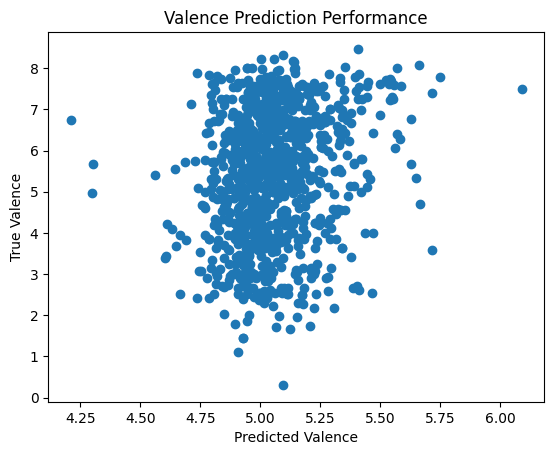

In [86]:
valence_true = data['valence_tags'].iloc[sample]
valence_pred = pred[:, 0]
plt.scatter(valence_pred, valence_true)
plt.xlabel('Predicted Valence')
plt.ylabel('True Valence')
plt.title('Valence Prediction Performance')

Text(0.5, 1.0, 'Arousal Prediction Performance')

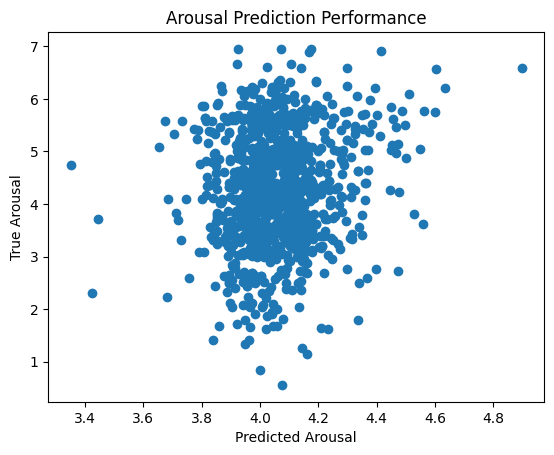

In [88]:
arousal_true = data['arousal_tags'].iloc[sample]
arousal_pred = pred[:, 1]
plt.scatter(arousal_pred, arousal_true)
plt.xlabel('Predicted Arousal')
plt.ylabel('True Arousal')
plt.title('Arousal Prediction Performance')

Text(0.5, 1.0, 'Dominance Prediction Performance')

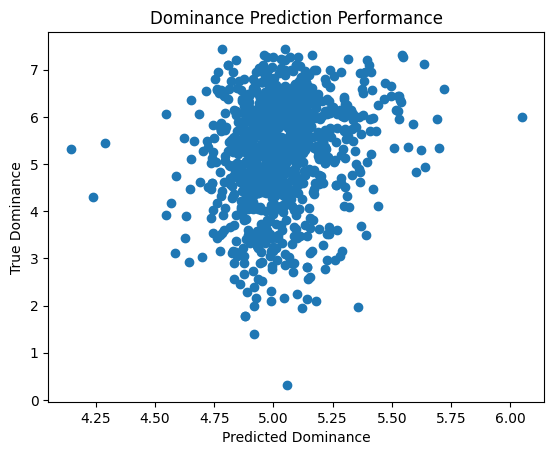

In [89]:
dominance_true = data['dominance_tags'].iloc[sample]
dominance_pred = pred[:, 2]
plt.scatter(dominance_pred, dominance_true)
plt.xlabel('Predicted Dominance')
plt.ylabel('True Dominance')
plt.title('Dominance Prediction Performance')